keras version:  2.2.0
TensorFlow version:  1.7.1

Loading images...
Getting dicom images
/vol/vssp/cvpwrkspc01/scratch/wm0015/download/prem/Segments/
1176  Files found
Loading images...
/vol/vssp/cvpwrkspc01/scratch/wm0015/download/prem/2D/my/6mm_c95
179  Files found
Loading images...
tmp[0].shape:  (179, 429, 429, 1)
tmp[1].shape:  (179, 429, 429, 1)
data[Img].shape =  (358, 429, 429, 1)
data[Img].shape =  (358, 429, 429, 3)
data[classlength][0]:  179
data[classlength][1]:  179
labels0.shape:  (179, 2)
label0:
 [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 

splitRatio:  0.9
splitPoint:  322
TrainLabels.shape:  (322, 2)
TrainLabels: 
 [[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0.

/user/HS204/wm0015/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/callbacks.py:432: RuntimeWarning: Can save best model only with val_accuracy available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


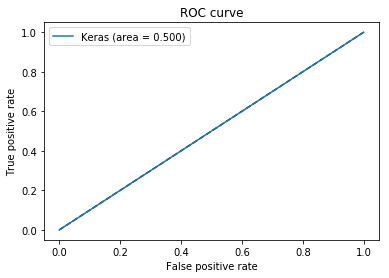

The score is......
 [7.1245509253607855, 0.5555555555555556]
Sensitivity:
y_true:
 [0 0 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 1 0 0 1 1 1 1 0 1 1 1 0 0 1 1] 
y_score:
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 tn:  0  fp:  16  fn:  0  tp:  20
Specificity:
y_true:
 [0 0 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 1 0 0 1 1 1 1 0 1 1 1 0 0 1 1] 
y_score:
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 tn:  0  fp:  16  fn:  0  tp:  20
Sensitivity:  1.0
Specificity:  0.0
shuffleMask:  [337 286 352 315 302  42 259  88  63 289 247 132 111 354 345 114  78 155
 266 142 119 256 296 244 250  13 238 335 235 221 198 139 105 173 202 150
  34 314  55  16  83  86 125 342 272 101 260 241  44 199 350  82 246 355
 278 263  68 239 128  17  60 136 343 170 174  81 339 251 328 255  70 117
 257  14 309 184 293 218 200 194  24 228  80 292 212 300 303 153  28 322
  66  77 240 338 110

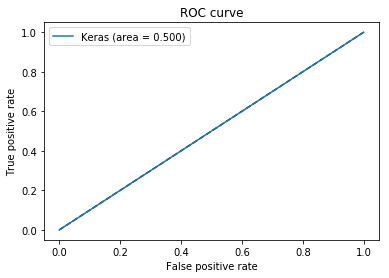

The score is......
 [7.569835133022732, 0.5277777777777778]
Sensitivity:
y_true:
 [1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0 1 1 1 0 1 1 0 0 1 1 0 0 1 0 0] 
y_score:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 tn:  19  fp:  0  fn:  17  tp:  0
Specificity:
y_true:
 [1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0 1 1 1 0 1 1 0 0 1 1 0 0 1 0 0] 
y_score:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 tn:  19  fp:  0  fn:  17  tp:  0
Sensitivity:  0.0
Specificity:  1.0
shuffleMask:  [133  81 187 261  38 276  40  57  85  36   9 327 320 149 115 234 189 125
 152 131  75  80 278 128 257 243 266 322 146  60 264 119 118 319 246 291
 271 251 201 230 104  35 260 315   5 159  10  66 281 335   3 165 134 218
  91 267  17  26 154 111  77 224 129 310 213 304 314  12  46 158  61  51
 108 157  42 140 101  20 227 345 105 285 228 162 195 229 279 136 270 258
  84 123 200 176 309 

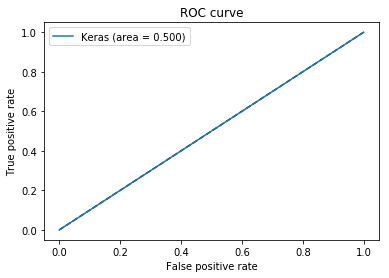

The score is......
 [7.124550395541721, 0.5555555555555556]
Sensitivity:
y_true:
 [0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0 0 0 0 1] 
y_score:
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 tn:  0  fp:  16  fn:  0  tp:  20
Specificity:
y_true:
 [0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0 0 0 0 1] 
y_score:
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 tn:  0  fp:  16  fn:  0  tp:  20
Sensitivity:  1.0
Specificity:  0.0
shuffleMask:  [  7  47  61 354 352 310 279 104 261 317   0 183 301 207  48 353 122 350
   1 267 100 138 153 316 303 335 224 324  87 340   2  91 185  60 118 142
 330 321 195 159 101  37 130  73  89 339 216 311 291  28 314  95 172 252
 242 212 110  74  31  69  46 319 278  10  36  94 323  13 124 198 103 349
  22  43  20 338 277 322 137  54  29 270 236  76 345   6 238   9 204  49
  44 258 173 286 166 

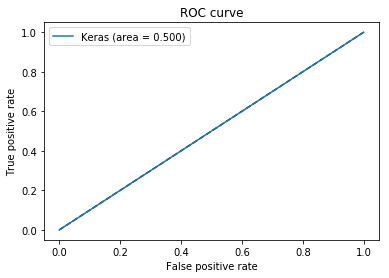

The score is......
 [8.46040407816569, 0.4722222222222222]
Sensitivity:
y_true:
 [1 1 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 1 0 0 1 1 0 0 1] 
y_score:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 tn:  17  fp:  0  fn:  19  tp:  0
Specificity:
y_true:
 [1 1 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 1 0 0 1 1 0 0 1] 
y_score:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 tn:  17  fp:  0  fn:  19  tp:  0
Sensitivity:  0.0
Specificity:  1.0
shuffleMask:  [260 161 211  19 151 252 171 164 283  69 321  60 282  97 256 139 137  18
 289 246 329  38 328 238 313 198  45  48  88 334 346 187  39  77 236 269
  67  80 158 332 232 326 105 291 331 356  36 168 340 306 140 199 272 188
 189 293 212 195 134 172 201 292 279 337 255  42 300 241 173 251 227 146
 130   4 144 109  98 316 309 242 170 125  65 197   1  85  58 347 325 280
  31 145 120 240 152 1

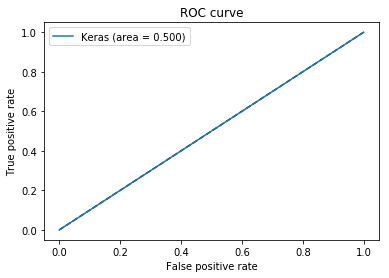

The score is......
 [8.905688603719076, 0.4444444444444444]
Sensitivity:
y_true:
 [0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0 0 1 1 0 1 1 1 0 1 0 1 0] 
y_score:
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 tn:  0  fp:  20  fn:  0  tp:  16
Specificity:
y_true:
 [0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0 0 1 1 0 1 1 1 0 1 0 1 0] 
y_score:
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 tn:  0  fp:  20  fn:  0  tp:  16
Sensitivity:  1.0
Specificity:  0.0
shuffleMask:  [334 108 200 113  75  74 306 313  52 183  27 138 328 278 134 238  97 199
 204 150  96  17  68 247 266 316 240 284 149 128 325 337 178 251  64  54
 357  32 223 114  59 158  91   9 206 349 133 354  85 255 161 249  79 124
  44 288 112 291 205 151  65 305 326 279  90 246 215 103 216  14 342 237
  80 312 274 303 181 203 256 356  25 254 290   4 273 140 145 322  93 229
 258 218  34 170 236 

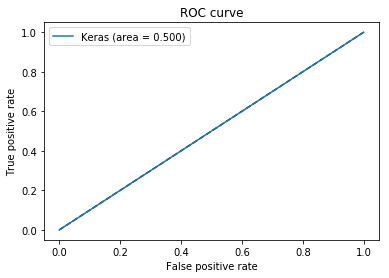

The score is......
 [7.124550395541721, 0.5555555555555556]
Sensitivity:
y_true:
 [0 0 1 1 1 1 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 1 1 0 1] 
y_score:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 tn:  20  fp:  0  fn:  16  tp:  0
Specificity:
y_true:
 [0 0 1 1 1 1 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 1 1 0 1] 
y_score:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 tn:  20  fp:  0  fn:  16  tp:  0
Sensitivity:  0.0
Specificity:  1.0
shuffleMask:  [245 272  85  92  20 283 144 185  63 217 131 116 265   9  69  25 301 216
 134 318 257  39 312 128  17 297 233 157 342 171 163 300  65 328 345 275
 100 324 160 280 329  52 277 234 344 264 302  60  49 295 236 224 113 205
 321 209 166 254  43 109  41  86 340  21 146 227   2  58 167  33 198 197
 268  31   3 355 105  66 102 292 287   1  77 126 339 247 327 122 112  70
  98 285  79 149 111 

In [ ]:
# fold
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
import keras
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import optimizers
# For some reason I have to tell it to use TensorFlows dimension ordering
from keras import backend as K
K.set_image_dim_ordering('tf')
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from time import time
import os
import tensorflow as tf
from keras import applications
from keras.utils import multi_gpu_model
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.visible_device_list = "2,3"
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

# Globals
VERBOSE = 0
ARCHITECTURE = 0
NORMALISE = 1
# Class 0 = backgrounds
# Prem..
CLASSDIR_0 = '/vol/vssp/cvpwrkspc01/scratch/wm0015/download/prem/Segments/'#P_Tomo_6CMBCF_XYZ_5*'
CLASSDIR_1 = '/vol/vssp/cvpwrkspc01/scratch/wm0015/download/prem/2D/6mm/'#P_6CMBCF*'
CLASSDIR_0 = '/vol/vssp/cvpwrkspc01/scratch/wm0015/download/prem/Segments/'#P_Tomo_6CMBCF_XYZ_5*'
CLASSDIR_1 = '/vol/vssp/cvpwrkspc01/scratch/wm0015/download/prem/2D/my/6mm_c95'#P_6CMBCF*

# CLASSDIR_0 = '/vol/vssp/cvpwrkspc01/scratch/wm0015/download2/4AFC-study-data/BgTomoFiltered_visualcheck_6mm'
# CLASSDIR_1 = '/vol/vssp/cvpwrkspc01/scratch/wm0015/download2/4AFC-study-data/Final_dataset/2D/6mm'
# CLASSDIR_0 = '/vol/vssp/cvpwrkspc01/scratch/wm0015/crops256/malignant/1.2.840.113619.2.227.2079*'
# CLASSDIR_1 = '/vol/vssp/cvpwrkspc01/scratch/wm0015/crops256/malignant/1.2.840.113619.2.227.2079*'
# CLASSDIR_0 = '/vol/vssp/cvpwrkspc01/scratch/wm0015/crops256/normal/*'
# CLASSDIR_1 = '/vol/vssp/cvpwrkspc01/scratch/wm0015/crops256/malignant/*'

# Calcs
# CLASSDIR_0 = '/user/HS204/wm0015/student/allCalcs/0/*'
# CLASSDIR_1 = '/user/HS204/wm0015/student/allCalcs/1/*'
MODEL_SAVE = '/vol/vssp/cvpwrkspc01/scratch/wm0015/models/best_model.h5'
BATCH_SIZE = 100
EPOCHS = 50
SPLIT_RATIO = 0.9
INPUT_SHAPE = [429, 429, 3]
# INPUT_SHAPE = [256, 256, 3]
#INPUT_SHAPE = [385, 385, 3]
FOLDS = 10
PATIENCE = 500

class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='/vol/vssp/mammo2/will/logs/new', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        fCount=0
        while os.path.exists(os.path.join(log_dir, 'training' + '_' + str(fCount))):
            fCount+=1
        training_log_dir = os.path.join(log_dir, 'training' + '_' + str(fCount))
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation' + '_' + str(fCount))

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()

    
        
def getSensitivityCallback(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
def getSpecificityCallback(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())        

def getBitDepth(img):
    print('Bit depth: img.shape: ', img.shape)
    print('img.shape: ', img.shape)
    maxmax = 0
    count = 0
    for _ in img:
        count += 1
        print(np.amax(_), ' ', count)
        if np.amax(_) > maxmax:
            maxmax = np.amax(_)
    return maxmax

def get_labels_one_hot(num_classes, class_id, num_samples):
    x = np.zeros((num_samples, num_classes))
    x[np.arange(num_samples),class_id] = 1
    return x

def fourCNN():
    model = Sequential()
    # Layer 1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=INPUT_SHAPE, data_format='channels_last'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 2
    model.add(Conv2D(32, (3,3), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 3    
    model.add(Conv2D(32, (3,3), activation='relu'))  
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 4     
    model.add(Conv2D(32, (3,3), activation='relu'))   
    model.add(MaxPooling2D(pool_size=(2, 2)))    
    # Layer 5     
    #model.add(Conv2D(32, (3,3), activation='relu'))   
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 6
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    return model
    
def fiveCNN():
    model = Sequential()
    # Layer 1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=INPUT_SHAPE, data_format='channels_last'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 2
    model.add(Conv2D(32, (3,3), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 3    
    model.add(Conv2D(32, (3,3), activation='relu'))  
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 4     
    model.add(Conv2D(32, (3,3), activation='relu'))   
    model.add(MaxPooling2D(pool_size=(2, 2)))    
    # Layer 5     
    model.add(Conv2D(32, (3,3), activation='relu'))   
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 6
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))  
    return model
    
def bigCNN():
    model = Sequential()
    # Layer 1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=INPUT_SHAPE, data_format='channels_last'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 2
    model.add(Conv2D(64, (3,3), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 3    
    model.add(Conv2D(124, (3,3), activation='relu'))  
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 4     
    model.add(Conv2D(256, (3,3), activation='relu'))   
    model.add(MaxPooling2D(pool_size=(2, 2)))    
    # Layer 5     
    model.add(Conv2D(512, (3,3), activation='relu'))   
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 6
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))  
    return model

def vgg():
    vggModel = applications.VGG19(weights = 'imagenet', include_top=False, input_shape = INPUT_SHAPE)
    # Add custom final layer
    model = vggModel.output
    model = Flatten()(model)
    model = Dense(2, activation='softmax')(model)
    model = keras.models.Model(inputs=vggModel.input, outputs=model)
    return model

def tlVGG(train_data, val_data):
    print('Compute bottleneck features...')
    vggModel = applications.VGG19(weights = "imagenet", include_top=False, input_shape = INPUT_SHAPE)
    # Freeze all layers
    for layer in vggModel.layers:
        layer.trainable = False
    # Add custom final layer
    bNModel = vggModel.output
    bNModel = Flatten()(bNModel)
    final_model = keras.models.Model(inputs=vggModel.input, outputs=bNModel)
    train_bNFeatures = {'img': 0, 'label': train_data['label']}
    val_bNFeatures = {'img': 0, 'label': val_data['label']}
    train_bNFeatures['img'] = final_model.predict(train_data['img'], batch_size=16)
    val_bNFeatures['img'] = final_model.predict(val_data['img'], batch_size=16)
    #Undo one hot - ROC does not work with onehot
    val_bNFeatures.update({'labelIndex': np.where(val_data['label']==1)[1]})
    print('train_bNFeatures[img].shape = ', train_bNFeatures['img'].shape)
    print('val_bNFeatures[img].shape = ', val_bNFeatures['img'].shape)

    print('Train head...')
    head = Sequential()
    #head.add(Dense(32, input_dim=train_bNFeatures['img'].shape[1], activation='relu'))
    head.add(Dense(2, activation='softmax'))    
    return head, train_bNFeatures, val_bNFeatures

    # Why oh why are they in a directory structure like this
def getPremFiles(imgPath, dataSpecs):
    import pydicom
    from fnmatch import fnmatch
    # First get all the 6mm lesions
    fileList = []
    for path, subdirs, files in os.walk(imgPath):
        for name in files:
            if fnmatch(name, '2D_dim2d.dcm'):
                fileList.append(os.path.join(path, name))
    # I can't remember why I thought dataSpecs was a good idea
    # I suppose this means that class 0 needs to be loaded in first
    dataSpecs['classLength'].append(len(fileList))
    
    # Load the files from filelist into an array
    print(len(fileList), ' Files found')
    print('Loading images...')
    dicomImg = np.asarray([])
    count = 0
    for f in fileList:
        dicomImg = np.append(dicomImg, pydicom.dcmread(f).pixel_array)
        count += 1
        print(count, '/', len(fileList))
    return dicomImg

def getDicomImages(data, paths, strMatch = '*.dcm', verbose = True):  
    print('Getting dicom images')
    import pydicom
    from fnmatch import fnmatch
    # Get file paths of images
    tmp = [[],[]]
    for index, p in enumerate(paths):
        fileList = []
        print(p)
        for path, subdirs, files in os.walk(p):
            for name in files:
                if fnmatch(name, strMatch): # '2D_dim2d.dcm'
                    fileList.append(os.path.join(path, name))
        data['classLength'].append(len(fileList))
        if len(fileList) == 0:
            print('MY_ERROR: NO FILES FOUND')
        # Load the files from filelist into an array
        print(len(fileList), ' Files found')
        print('Loading images...')
        data['img'] = np.asarray([])
        count = 0
        for f in fileList:
            tmp[index] = np.append(tmp[index], pydicom.dcmread(f).pixel_array)
            count += 1
            if verbose == True:
                print(count, '/', len(fileList))
    # Reshape the images
    tmp[0] = tmp[0].reshape((-1, INPUT_SHAPE[0], INPUT_SHAPE[1], 1))
    tmp[0] = tmp[0][0:data['classLength'][1],:,:,:] #210
    tmp[1] = tmp[1].reshape((-1, INPUT_SHAPE[0], INPUT_SHAPE[1], 1))
    
    # Update class length
    data['classLength'][0] = tmp[0].shape[0]
    data['classLength'][1] = tmp[1].shape[0]
    
    # Concatenate the classes
    print('tmp[0].shape: ', tmp[0].shape)
    print('tmp[1].shape: ', tmp[1].shape)
    data['img'] = np.concatenate((tmp[0],tmp[1]))
    # Add the channels
    print('data[Img].shape = ', data['img'].shape)
    data['img'] = np.concatenate((data['img'], data['img'], data['img']), axis = 3)
    print('data[Img].shape = ', data['img'].shape)
    return data

# For non dicom images
def getImages(data, paths):    
    print('Getting non-dicom images')
    tmp = [[],[]]
    for index, p in enumerate(paths):
        fileList = glob.glob(p) #'BengaliBMPConvert/*.bmp' 
        data['classLength'].append(len(fileList))
        tmp[index] = np.array([(cv2.imread(fname)) for fname in fileList])
    print('tmp[0].shape: ', tmp[0].shape)
    print('tmp[1].shape: ', tmp[1].shape)
    data['img'] = np.concatenate((tmp[0], tmp[1]))
    return data

def getImagesOld(path, dataSpecs):
    fileList = glob.glob(path) #'BengaliBMPConvert/*.bmp'   
    num = len(fileList)
    dataSpecs['classLength'].append(len(fileList))
    x = np.array([(cv2.imread(fname)) for fname in fileList])
    return x

    # Comment out for prem images
#     data['img'] = np.concatenate((
#             get_images(CLASSDIR_0, dataSpecs), # Class 0 (backgrounds)
#             get_images(CLASSDIR_1, dataSpecs) # Class 1 
#     ))         


def colourDrop3to1(data):   
    data['img'] = data['img'][:,:,:,0]
    data['img'] = np.reshape(data['img'], (data['img'].shape[0],data['img'].shape[1],data['img'].shape[2],1))
    print('new data shape = ', data['img'].shape)
    return data

def getSensitivity(y_true, y_score):
    y_score = np.rint(y_score)
    tn, fp, fn, tp = confusion_matrix(y_true, y_score, labels=[0,1]).ravel()
    print('Sensitivity:\ny_true:\n', y_true, '\ny_score:\n', y_score)
    print(' tn: ', tn, ' fp: ', fp, ' fn: ', fn, ' tp: ', tp)
    return tp/(tp+fn)
def getSpecificity(y_true, y_score):
    y_score = np.rint(y_score)
    tn, fp, fn, tp = confusion_matrix(y_true, y_score, labels=[0,1]).ravel()
    print('Specificity:\ny_true:\n', y_true, '\ny_score:\n', y_score)
    print(' tn: ', tn, ' fp: ', fp, ' fn: ', fn, ' tp: ', tp)
    return tn/(tn+fp)


    
def main():
    import keras
    print('keras version: ', keras.__version__)
    print('TensorFlow version: ', tf.__version__)
    print('\nLoading images...')
    
    # Get images
    data = {'img': 0, 'label': 0, 'classLength':[]}
    #data = getImages(data, (CLASSDIR_0, CLASSDIR_1))
    #data = getDicomImages(data, (CLASSDIR_0, CLASSDIR_1))
    data = getDicomImages(data, (CLASSDIR_0, CLASSDIR_1), strMatch = '2D_dim2d.dcm', verbose = False)
    # Create one hot labels
    print('data[classlength][0]: ', data['classLength'][0])
    print('data[classlength][1]: ', data['classLength'][1])
    labels0 = get_labels_one_hot(2, 0, data['classLength'][0])
    labels1 = get_labels_one_hot(2, 1, data['classLength'][1])
    print('labels0.shape: ', labels0.shape)
    print('label0:\n', labels0)
    print('labels1.shape: ', labels1.shape)
    print('labels1:\n', labels1)
    
                              
#     data['label'] = np.concatenate((
#             get_labels_one_hot(2, 0, data['classLength'][0]), # Class 0 
#             get_labels_one_hot(2, 1, data['classLength'][1]))) # Class 1
    data['label'] = np.concatenate((labels0, labels1))
    
    print('data[label].shape: ', data['label'].shape)
    print('onehot class 0:\n', get_labels_one_hot(2, 0, data['classLength'][0]))
    print('onehot class 1 :\n', get_labels_one_hot(2, 1, data['classLength'][1]))
    print('data[label]class0:\n', data['label'][0:10])
    print('data[label]class1:\n', data['label'][600:610])
    # Get bit depth
#     print('Bit depth: ', getBitDepth(data['img']))
#     return
    # Normalise
    data['img'] = data['img']/NORMALISE 
    
    #data = colourDrop3to1(data)
     
    # After this things get a bit messy
    #___________________________________________________



    
    valStats = {'score':[], 'specificity':[], 'sensitivity':[]}
    for crossVal in range(FOLDS):

        # Shuffle data
        seed = 33
        #np.random.seed(seed) # Has to be set before each use of random
        shuffleMask = np.random.permutation(data['img'].shape[0])    
        print('shuffleMask: ', shuffleMask)
        data['img'] = data['img'][shuffleMask, :, :, :]
        data['label'] = data['label'][shuffleMask, :]
        # Split traing and validation data        
        splitRatio = SPLIT_RATIO
        print('splitRatio: ', splitRatio)
        splitPoint = math.floor(data['img'].shape[0]*splitRatio)
        print('splitPoint: ', splitPoint)
        train_data = {'img': data['img'][0:splitPoint], 'label': data['label'][0:splitPoint]}
        val_data = {'img': data['img'][splitPoint:], 'label': data['label'][splitPoint:]}
        print('TrainLabels.shape: ', train_data['label'].shape)
        print('TrainLabels: \n', train_data['label'])
        print('val_data.shape: ', val_data['label'].shape)
        print('val_data: \n', val_data['label'])
        #Undo one hot - ROC does not work with onehot
        val_data.update({'labelIndex': np.where(val_data['label']==1)[1]})

        

        #model, train_data, val_data = tlVGG(train_data, val_data)
        model = fiveCNN()
        model = multi_gpu_model(model, gpus=2)
        if ARCHITECTURE != 0:
            model.summary()  
        
        sgd = optimizers.SGD(lr=5, decay=1e-6, momentum=0.9, nesterov=True)
        adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) #0.001
        model.compile(loss='binary_crossentropy',
                    optimizer=adam,
                     metrics=['accuracy'])#, getSensitivityCallback, getSpecificityCallback])
        tensorboard = TensorBoard(log_dir='/vol/vssp/mammo2/will/logs/new'.format(time()), write_images=True)

        # Data augmentation settings
        if (1 == 2):
            from keras.preprocessing.image import ImageDataGenerator
            trainDatagen = ImageDataGenerator(
                featurewise_center=True,
                featurewise_std_normalization=True,
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                horizontal_flip=True)
            trainDatagen.fit(train_data['img'])
            valDatagen = ImageDataGenerator(
                featurewise_center=True,
                featurewise_std_normalization=True,
                #rotation_range=20,
                #width_shift_range=0.2,
                #height_shift_range=0.2,
                #horizontal_flip=True
                )
            valDatagen.fit(val_data['img'])
        
#         # Normalise myself
#         mean_data = np.mean(train_data['img'])
#         std_data = np.std(train_data['img'])
#         train_data['img'] = (train_data['img']-mean_data)/std_data
#         val_data['img'] = (val_data['img']-mean_data/std_data)
        
#        # Train, with data augmentation
#         print('Train...')
#         model.fit_generator(trainDatagen.flow(train_data['img'], train_data['label'], batch_size=32),
#                     steps_per_epoch=len(train_data['img']) / 32, epochs=EPOCHS, verbose=VERBOSE,
#                            callbacks=[
#                                TrainValTensorBoard(write_graph=False),
#                                EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1),
#                                ModelCheckpoint(filepath=MODEL_SAVE, monitor='val_accuracy', save_best_only=True)],
#                            validation_data=valDatagen.flow(x = val_data['img'], y = val_data['label']))
        

        
        
        
        # Train
        print('Train...')
        model.fit(train_data['img'], train_data['label'], 
                batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE,
                callbacks=[
                    TrainValTensorBoard(write_graph=False),
                    EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1),
                    ModelCheckpoint(filepath=MODEL_SAVE, monitor='val_accuracy', save_best_only=True)],
                validation_data=(val_data['img'], val_data['label']))
        
        # Restore best model
        #model.load_weights(MODEL_SAVE)
        
        # Produce ROC curve
        
        y_pred_keras = model.predict(val_data['img'])  
        y_true = val_data['labelIndex']
        y_score = y_pred_keras[:,1]
        fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_score)
        from sklearn.metrics import auc
        auc_keras = auc(fpr_keras, tpr_keras)
        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        plt.show()
        



        # Evaluate
        score = model.evaluate(val_data['img'], val_data['label'], verbose=0)
        valStats['score'].append(score)
        print('The score is......\n', score)
        valStats['sensitivity'].append(getSensitivity(y_true, y_score))
        valStats['specificity'].append(getSpecificity(y_true, y_score))
        print('Sensitivity: ', valStats['sensitivity'][-1])
        print('Specificity: ', valStats['specificity'][-1])
  

    valStatsScore = np.asarray(valStats['score'])
    print('Validations: \n', valStatsScore[:, 1])
    print('Average loss: ', sum(valStatsScore[:, 0])/FOLDS)
    print('Average validation: ', sum(valStatsScore[:, 1])/FOLDS)
    print('\n\nSensitivities: \n', valStats['sensitivity'])
    print('\nSpecificities: \n', valStats['specificity'])
    print('\n\nAverage sensitivity: ', sum(valStats['sensitivity'])/len(valStats['sensitivity']))
    print('Average specificity: ', sum(valStats['specificity'])/len(valStats['specificity']))
    
if __name__ == "__main__":
    main()

In [5]:
print('hello world')

hello world


In [28]:
CLASSDIR_0 = '/vol/vssp/cvpwrkspc01/scratch/wm0015/download/prem/Segments'
CLASSDIR_1 = '/vol/vssp/cvpwrkspc01/scratch/wm0015/download/prem/2D/6mm'

def test(x):
    for _ in x:
        print(_)
test((CLASSDIR_0, CLASSDIR_1))

/vol/vssp/cvpwrkspc01/scratch/wm0015/download/prem/Segments
/vol/vssp/cvpwrkspc01/scratch/wm0015/download/prem/2D/6mm


In [35]:
x = [[6.5308382717179665, 0.5925925925925926], [0.16470135086112553, 0.9444444444444444], [0.15422181794304907, 0.9444444444444444], [0.19875195217721256, 0.9382716049382716]] 
x = np.asarray(x)
print(x, '\n')
print(x[0][0])
print(x[:, 0])
print(x.shape)

[[6.53083827 0.59259259]
 [0.16470135 0.94444444]
 [0.15422182 0.94444444]
 [0.19875195 0.9382716 ]] 

6.5308382717179665
[6.53083827 0.16470135 0.15422182 0.19875195]
(4, 2)
